# 1. Objetivo

El objetivo principal de esta práctica es estudiar la opinion de la población de Madri dvía tweeter de la gestión de Manuela Carmena y el grupo Ahora Madrid sobre la ciudad.

Como subojetivos, se pretendía mostrar en un mapa la geolocalización de los tweets para identificar visualmente las zonas con mejor y peor reputación.

Por último, a partir de la información obtenida, se pretende crear un grafo para tratar de identificar comunidades de votantes, gente con mayor centralidad a la hora de hablar positivamente o negativamente del grupo y ver la repercusion medíatica de los mismos.

In [1]:
import json
import pandas as pd
import numpy as np
import re
import nltk

El código de ingesta se ha realizado con un IDE IntellyJ debido a la facilidad de depuración de los datos obtenidos vía tweeter. Se entregará con la práctica

Si bien, una vez ingestados durante un periodo de un par de días, se carga el fichero con los tweets que hacen referencia a Manuea Carmena. El procesamiento de cada tweet, así como de los usuarios que los publican o retweetean se gestiona con estas dos funciones.

Es importante el procesamiento de los tweets, ya que se eliminan URLs, el usuario que se menciona, elimina espacios en blanco,y elimina duplicados via regex

In [ ]:
def processUser(tweet,df):
    userId = int(tweet['user']['id'])
    name = tweet['user']['screen_name']
    location = tweet['user']['location']
    url = tweet['user']['url']
    followers = tweet['user']['followers_count']
    lang = tweet['user']['lang']
    profile_image = tweet['user']['profile_image_url']
    following = tweet['user']['following']
    followers = tweet['user']['followers_count']
    df.loc[userId] = [name,location,url,followers,lang,profile_image,following,followers]

#Proceso de Tweets
def processTweet(tweet):
    tweet = tweet.lower()
    # www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #@username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    #print tweet
    return tweet


Generamos sendos datasets para una mayor facilidad a la hora de manejar la información

In [4]:
dfusers = pd.DataFrame(columns=['name','location','url','followers','lang','profile_image','following','followers'])
dftweets = pd.DataFrame(columns=['userId','user_name','user_desc','user_url','user_followers','user_image','user_following',
                                'geo','coordinates','timestamp','tweet','source','isretweeted','autor_id','autor_name','autor_desc','autor_followers',
                                'autor_following','lang','lat','lon', 'polarity'])

Abrimos el fichero y procesamos cada un de los tweets, almacenados en formato JSON

In [31]:
file = open('C:\\Users\\Alberto\\PycharmProjects\\twitterExtraction\\CarmenaTweets.txt','r')
decoded = ''
counter = 0
for line in file:
    counter+=1
    
    try:
        if counter==1:
                print line
        decoded = json.loads(line)
    except Exception as e:
        print e,':',decoded['id'] 
        
    try:
        id = decoded['id']
        userId = decoded['user']['id']
        user_name = decoded['user']['screen_name']
        user_desc = decoded['user']['description']
        user_url = decoded['user']['url']
        user_followers = decoded['user']['followers_count']
        user_image = decoded['user']['profile_image_url']
        user_following = decoded['user']['following']
        #print decoded['user']['id']
        processUser(decoded, dfusers)
        geo = decoded['geo']
        coordinates = decoded['coordinates']
        timestamp = decoded['timestamp_ms']
        tweet = decoded['text']
        tweet = tweet.lower()
        # www.* or https?://* to URL
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
        #@username to AT_USER
        tweet = str(re.sub('@[^\s]+','AT_USER',tweet))
        #Remove additional white spaces
        tweet = re.sub('[\s]+', ' ', tweet)
        #Replace #word with word
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
        #trim
        tweet = tweet.strip('\'"') 
        source = decoded['source']
        isretweeted = False 
        if 'retweeted_status' in decoded:
            if decoded['retweeted_status'] is not 'null':
                isretweeted = True
                autor_id = decoded['retweeted_status']['user']['id']
                autor_name = decoded['retweeted_status']['user']['screen_name']
                autor_desc = decoded['retweeted_status']['user']['description']
                autor_followers = decoded['retweeted_status']['user']['followers_count']
                autor_following = decoded['retweeted_status']['user']['following']
        lang = decoded['lang']
        lat = 'null'
        lon = 'null'
        polarity = 'null'
        try:
            dftweets.loc[id] = [userId,user_name,user_desc,user_url,user_followers,user_image,user_following,
                                geo,coordinates,timestamp,tweet,source,isretweeted,autor_id,autor_name,autor_desc,autor_followers,
                                autor_following,lang,lat,lon, polarity]
        except Exception as e:
            print e
    except Exception as a:
        print a.args,':','error processing tweet'

{"created_at":"Sun Nov 20 15:11:52 +0000 2016","id":800355989086203905,"id_str":"800355989086203905","text":"RT @elmundoes: El edificio (no okupado) que posee en Barcelona la concejal de Carmena que defiende a los okupas en Madrid\u2026 ","source":"\u003ca href=\"http:\/\/twitter.com\" rel=\"nofollow\"\u003eTwitter Web Client\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":799032032017993733,"id_str":"799032032017993733","name":"GRUPO METRO MENDOZA","screen_name":"GRUPO_METRO_MZA","location":"Mendoza, Argentina","url":"http:\/\/www.grupometromza.com","description":"GRUPO METRO MENDOZA.\nPRODUCTORA DE SE\u00d1AL Y CONTENIDOS PARA RADIO Y TV . AGENCIA DE PUBLICIDAD Y PROMOCIONES PUBLICITARIAS.\nRADIOS AM Y FM . DIARIOS DIGITALES.","protected":false,"verified":false,"followers_count":24,"friends_count":353,"listed_count":5,"favourites_count"

Comprobamos la estructura de los campos obtenidos que nos interesan

In [9]:
dftweets.head(2)

,userId,user_name,user_desc,user_url,user_followers,user_image,user_following,geo,coordinates,timestamp,...,isretweeted,autor_id,autor_name,autor_desc,autor_followers,autor_following,lang,lat,lon,polarity
800355989086203905,7.990320e+17,GRUPO_METRO_MZA,GRUPO METRO MENDOZA.\nPRODUCTORA DE SEÑAL Y CO...,http://www.grupometromza.com,24.0,http://pbs.twimg.com/profile_images/7990356908...,None,None,None,1479654712350,...,True,14436030.0,elmundoes,- Cuenta oficial del diario EL MUNDO - 📷 Sara...,2621501.0,None,es,null,null,null
800355991057530880,2.326149e+09,pepelopezperaza,None,None,329.0,http://pbs.twimg.com/profile_images/4310926238...,None,None,None,1479654712820,...,True,244101525.0,pmanglano,"Ante todo, mucha libertad. Concejal del Ayunta...",16754.0,None,es,null,null,null


Vemos la cantidad de tweets que tenemos a disposicion

In [11]:
len(dftweets)

7398

Observamos la informacion de los usuarios que publican cada uno de los tweets

In [12]:
dfusers.head(5)

,name,location,url,followers,lang,profile_image,following,followers
799032032017993733,GRUPO_METRO_MZA,"Mendoza, Argentina",http://www.grupometromza.com,24.0,es,http://pbs.twimg.com/profile_images/7990356908...,None,24.0
2326149346,pepelopezperaza,None,None,329.0,es,http://pbs.twimg.com/profile_images/4310926238...,None,329.0
752958026,Reiv4x,"Barcelona, España",None,62.0,es,http://pbs.twimg.com/profile_images/7344675448...,None,62.0
2382475370,xShyWolf_,Estudiando,None,112.0,es,http://pbs.twimg.com/profile_images/7888527558...,None,112.0
2405391592,angeljurado666,"Pedro Muñoz, Castilla-La Manch",None,304.0,es,http://pbs.twimg.com/profile_images/7508086238...,None,304.0


Numero de usuarios distintos obtenido

In [13]:
len(dfusers)

5573

Será necesario filtrar solo aquellos tweets que estén en español para ser capaz de analizar si sentimiento. COmo vemos, no es el mismo numero que el obtenido en la ingesta, lo que da pie a que haya tweets sin identificar el idioma, o bien en otros idiomas, nos da igual

In [14]:
len(dftweets[dftweets['lang']=='es'])

7317

Guardamos los dataframes para no volver a reprocesar los ficheros.

In [15]:
dftweets.to_csv('tweets_df.csv', encoding='utf-8')

In [16]:
dfusers.to_csv('users_df.csv', encoding='utf-8')

## 2. Cargamos los dataframes con datos obtenidos en streaming 
Este paso se incluyo para evitar el reprocesamiento en la realizacion de la práctica


In [17]:
dftweets = pd.read_csv('tweets_df.csv', encoding='utf-8')

In [18]:
dfusers= pd.read_csv('users_df.csv', encoding='utf-8')

Se ha obtenido el corpus de TASS donde vienen tagueandos un amplio conjunto de tweets. Lo utilizaremos como entrenamiento del modelo

In [19]:
from lxml import objectify
xml = objectify.parse(open('general-tweets-train-tagged.xml'))
#sample tweet object
general_tweets_corpus_train = pd.DataFrame(columns=('content', 'polarity', 'agreement'))
root = xml.getroot()
tweets = root.getchildren()
for i in range(0,len(tweets)):
    tweet = tweets[i]
    row = dict(zip(['content', 'polarity', 'agreement'], [tweet.content.text, tweet.sentiments.polarity.value.text, tweet.sentiments.polarity.type.text]))
    row_s = pd.Series(row)
    row_s.name = i
    general_tweets_corpus_train = general_tweets_corpus_train.append(row_s)
general_tweets_corpus_train.to_csv('general-tweets-train-tagged.csv', index=False, encoding='utf-8')

In [20]:
general_tweets_corpus_train.head(5)

,content,polarity,agreement
0,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT
1,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,DISAGREEMENT
2,@marodriguezb Gracias MAR,P,AGREEMENT
3,"Off pensando en el regalito Sinde, la que se v...",N+,AGREEMENT
4,Conozco a alguien q es adicto al drama! Ja ja ...,P+,AGREEMENT


In [21]:
tweets_corpus = general_tweets_corpus_train.copy()
tweets_corpus = tweets_corpus.query('agreement != "DISAGREEMENT" and polarity != "NONE"')
tweets_corpus.head(5)

,content,polarity,agreement
2,@marodriguezb Gracias MAR,P,AGREEMENT
3,"Off pensando en el regalito Sinde, la que se v...",N+,AGREEMENT
4,Conozco a alguien q es adicto al drama! Ja ja ...,P+,AGREEMENT
6,Toca @crackoviadeTV3 . Grabación dl especial N...,P+,AGREEMENT
8,Buen día todos! Lo primero mandar un abrazo gr...,P+,AGREEMENT


Eliminamos aquellas cadenas con links dentro del TASS y verificamos el conjunto de tweets de entrenamiento. En este caso casi 5000

In [22]:
#remove links
tweets_corpus = tweets_corpus[-tweets_corpus.content.str.contains('^http.*$')]

tweets_corpus.shape

(4995, 3)

## 3. Ejecución del modelo

Ya que el TASS tiene 5 niveles de tagueado (Positivo +, Positivo, Neutro, None, Negativo y Negativo-) intentamos reducir agrupar los positivos, los negativos y sacar los neutros del conjunto de entrenamiento, para que ls resultados sean mas evidentes

In [23]:
general_tweets_corpus_train.ix[general_tweets_corpus_train['polarity']=='P+', 'polarity'] = 'P'
general_tweets_corpus_train.ix[general_tweets_corpus_train['polarity']=='N+', 'polarity'] = 'N'
general_tweets_corpus_train.ix[general_tweets_corpus_train['polarity']=='NONE', 'polarity'] = 'NEU'
general_tweets_corpus_train = general_tweets_corpus_train[general_tweets_corpus_train.polarity.str.contains("NEU") == False]


Extraemos solo un conjunto de 1500 tweets para entrenar el modeo (mas que nada porque no tengo potencia de computo y se quedaba colgado el ordenador)

In [24]:
subcorpus = []
general_tweets_corpus_train['words'] = general_tweets_corpus_train['content'].str.lower().str.split(' ')
general_tweets_corpus_train.head(5)
subcorpus = general_tweets_corpus_train[['words','polarity']]
tweets = [tuple(x) for x in subcorpus[0:1500].values]

Definimos las funciones neesarias para tokenizar y extraer las features de los tweets tagueados del corpus del TASS

In [25]:
def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
        all_words.extend(words)
    return all_words


def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features

word_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

Utilizamos las herramientas de la librería nltk para extraer las features del conjutno seleccionado del TASS y entrenar un modelo NaiveBayes de classificacion de tweets

In [26]:
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier

# get the training set and train the Naive Bayes Classifier
training_set = nltk.classify.util.apply_features(extract_features, tweets)

Entrenamos el clasificador con el subconjunto de train

In [27]:
NBClassifier = nltk.NaiveBayesClassifier.train(training_set)

Cargamos el dataframe de tweets ingestados, y añadimos una columna con la polaridad que nos da el modelo.

In [30]:
dftweets['tweet'].head(2)

0    rt AT_USER el edificio (no okupado) que posee ...
1    rt AT_USER lo de alsasua no es terrorismo. esp...
Name: tweet, dtype: object

In [46]:
import nltk
   
temp = dftweets[:20]
for i in range(len(dftweets)):
    #print dftweets.ix[i]['tweet'] 
    dftweets.set_value(i, 'polarity', NBClassifier.classify(
            extract_features(
                nltk.word_tokenize(
                    processTweet(
                        dftweets.ix[i]['tweet'])))))
    #print dftest.ix[i]['polarity'] 


rt at_user el edificio (no okupado) que posee en barcelona la concejal de carmena que defiende a los okupas en madrid… 
rt at_user lo de alsasua no es terrorismo. espinar no es casta. carmena no es de podemos. aragón es un país. bódalo es un preso polític…
rt at_user el 'cara al sol' cierra la misa en honor a franco en madrid. ahora hacer apología de la dictadura franquista lo lla… 
... podemos entrenar ahora si... quieres. no tengo nada que hacer a la tarde. nunca te voy a decir que no a entrenar, yo te lo pedí.
rt at_user 😂😂😂😂😂👇 url
rt at_user el edificio (no okupado) que posee en barcelona la concejal de carmena que defiende a los okupas en madrid… 
rt at_user el edificio (no okupado) que posee en barcelona la concejal de carmena que defiende a los okupas en madrid… 
rt at_user el edificio (no okupado) que posee en barcelona la concejal de carmena que defiende a los okupas en madrid… 
rt at_user el edificio (no okupado) que posee en barcelona la concejal de carmena que defiende a lo

AttributeError: 'float' object has no attribute 'lower'

In [48]:
len(dftweets)

7405

Almacenamos el conjutno de tweets analizada su polaridad para ser tratados de cara a la gestion del grafo y geoposicionamiento. 

In [49]:
dftweets.to_csv('tweets_analyzed.csv', encoding='utf-8')

Vemos en este caso como es la polaridad de un subconjutno de tweets analizados.

In [50]:
dftweets[['tweet','polarity']].head(50)

,tweet,polarity
0,rt AT_USER el edificio (no okupado) que posee ...,P
1,rt AT_USER lo de alsasua no es terrorismo. esp...,N
2,rt AT_USER el 'cara al sol' cierra la misa en ...,N
3,... podemos entrenar ahora si... quieres. no t...,P
4,rt AT_USER 😂😂😂😂😂👇 URL,P
5,rt AT_USER el edificio (no okupado) que posee ...,P
6,rt AT_USER el edificio (no okupado) que posee ...,P
7,rt AT_USER el edificio (no okupado) que posee ...,P
8,rt AT_USER el edificio (no okupado) que posee ...,P
9,rt AT_USER el 'cara al sol' cierra la misa en ...,N


In [52]:
import pandas as pd
postdf = pd.read_csv('tweets_analyzed.csv', encoding='utf-8')
postdf.head(2)

,Unnamed: 0,Unnamed: 0.1,userId,user_name,user_desc,user_url,user_followers,user_image,user_following,geo,...,isretweeted,autor_id,autor_name,autor_desc,autor_followers,autor_following,lang,lat,lon,polarity
0,0,800355989086203905,7.99032032018e+17,GRUPO_METRO_MZA,GRUPO METRO MENDOZA.\r\r\nPRODUCTORA DE SEÑAL ...,http://www.grupometromza.com,24.0,http://pbs.twimg.com/profile_images/7990356908...,NaN,NaN,...,True,14436030.0,elmundoes,- Cuenta oficial del diario EL MUNDO - 📷 Sara...,2621501.0,NaN,es,null,null,P
1,1,800355991057530880,2326149346.0,pepelopezperaza,NaN,NaN,329.0,http://pbs.twimg.com/profile_images/4310926238...,NaN,NaN,...,True,244101525.0,pmanglano,"Ante todo, mucha libertad. Concejal del Ayunta...",16754.0,NaN,es,null,null,N


## 4. Conclusiones

De 7398 tweets no hay ni uno solo geolocalizado con lo cual no se puede mostrar sobre un mapa las diferencias de opinion. 

In [53]:
len(postdf)-len(postdf[postdf['lon']=='null'])

10

Vemos que al menos en tweeter el sentimiento de la red es positivo hacia la gestion de Manuela Carmena y su grupo
Observamos tambien la proporcion de retweeteados y originales.

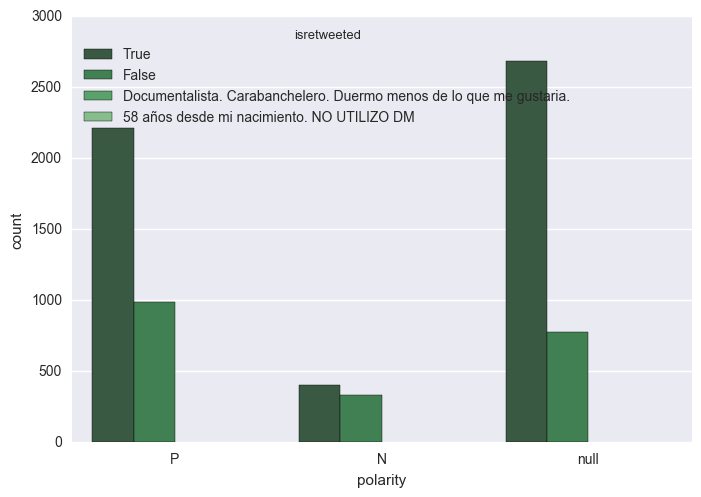

In [54]:
%matplotlib inline  
import seaborn as sns, numpy as np

sns.countplot(x="polarity",hue="isretweeted", data=postdf, palette="Greens_d");

Aunque la generacion del grafo no está completamente generada y depurada, la idea es tener algo similar a esto, con loc colores de la polaridad y la informacion de quien es el Autor y quien es el Retweeteador, viendo quienes son aquellos que generan mas contenido, y quienes lo retweetean

<img src="files/graph.png">